# EEP 136 Project 1 Deliverable

**Group John Graunt**

Introduction: We are Team Graunt, with members:
1. Guilherme Hoher - guilherme_hoher@berkeley.edu 
2. Xiaolong Wang - justinwx@berkeley.edu & https://github.com/Justinwxl
3. Shrija Malla - shrija@berkeley.edu & https://github.com/shrija-malla
4. Steven Zeng - k1519632@berkeley.edu & https://github.com/zengsteven

## Topics & Goals:

Our project focused on analyzing recent population trends in Saudi Arabia with a focus on migration and work patterns. In addition, we also analyzed some factors regarding the country's governance.

Our project goals included:
1. Better understanding possible socioeconomic and cultural reasons for migration in the region.
2. Analyzing relationships between other growing interests in the region and migration.

## Collaboration:

We collaborated using the following tools:

1. Google Docs for general asynchronous updates and planning
2. Deepnote for collaborative coding
3. Datahub for compiling the code to send off to Github
4. Github for hosting the project files

## Code

In [37]:
##Installing Data and Tools
%pip install wbdata
%pip install chart-studio
%pip install --upgrade pip
%matplotlib notebook
%matplotlib inline
import wbdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as pyo
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Deliverable 1: Population Statistics

In [38]:
import pandas as pd
import requests


def get_country_code(country_name):
    """
    Convert country name -> World Bank ISO3 country code.
    """
    url = "https://api.worldbank.org/v2/country?format=json&per_page=300"
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()

    # Validate API response structure
    if not (isinstance(data, list) and len(data) >= 2 and isinstance(data[1], list)):
        raise ValueError("Unexpected data format received from World Bank API.")

    # Iterate over list of countries to find matching name.
    for country in data[1]:
        if country.get("name", "").strip().lower() == country_name.strip().lower():
            return country.get("id")
    
    return None




def get_age_distribution(country_code, year):
    """
    Mock function to return age distribution percentages for a given country and year.
    This should ideally be replaced with real data from a reliable demographic source.
    """
    age_distributions = {
        "WLD": {0: 8, 5: 8, 10: 9, 15: 9, 20: 8, 25: 8, 30: 7, 35: 7,
                 40: 6, 45: 6, 50: 5, 55: 5, 60: 4, 65: 4, 70: 3, 75: 2,
                 80: 2, 85: 1},
        "USA": {0: 6, 5: 6, 10: 7, 15: 7, 20: 7, 25: 7, 30: 6, 35: 6,
                 40: 6, 45: 6, 50: 6, 55: 5, 60: 5, 65: 4, 70: 3, 75: 3,
                 80: 2, 85: 2}
    }
    return age_distributions.get(country_code, age_distributions["WLD"])

def estimate_population_in_age_range(total_population, age_range, age_distribution):
    """
    Estimate the population within the specified age range based on the age distribution.
    """
    lower, upper = age_range
    total_percentage = sum(v for k, v in age_distribution.items() if lower <= k <= upper)
    return int((total_percentage / 100) * total_population)

def population(year, sex, age_range, location):
    """
    Get the estimated population of a given country (or the world) based on year, sex, and age range.
    Returns a formatted string with the result.
    """
    
    sex = sex.lower().strip()
    sex_indicators = {
        "people": "SP.POP.TOTL", "p": "SP.POP.TOTL", "all": "SP.POP.TOTL", "everyone": "SP.POP.TOTL",
        "male": "SP.POP.TOTL.MA.IN", "males": "SP.POP.TOTL.MA.IN", "m": "SP.POP.TOTL.MA.IN", "ma": "SP.POP.TOTL.MA.IN",
        "female": "SP.POP.TOTL.FE.IN", "females": "SP.POP.TOTL.FE.IN", "f": "SP.POP.TOTL.FE.IN", "fe": "SP.POP.TOTL.FE.IN"
    }
    
    indicator = sex_indicators.get(sex, None)
    if indicator is None:
        return None
    
    if location.strip().lower() in ["world", "wld"]:
        country_code = "WLD"
        location_name = "the world"
    elif location.strip().lower() == "usa":
        country_code = "USA"
        location_name = "the United States"
    else:
        country_code = get_country_code(location)
        location_name = location
    
    if not country_code:
        return None
    
    url = f"https://api.worldbank.org/v2/country/{country_code}/indicator/{indicator}?date={year}&format=json"
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
    
    total_population = data[1][0].get("value", None)
    if total_population is None:
        return None
    
    age_distribution = get_age_distribution(country_code, year)
    estimated_population = estimate_population_in_age_range(total_population, age_range, age_distribution)

    sex_label = "people" if sex in ["p", "people", "everyone", "all"] else "males" if sex.startswith("m") else "females"
    lower, upper = age_range

    return f"In {year}, {estimated_population:,} {sex_label} aged {lower} to {upper} were living in {location_name}."

# Example queries:
print(population(2002, "p", [0, 4], "China"))
print(population(2020, "females", [10, 19], "United States"))
print(population(2023, "everyone", [20, 29], "WLD"))
print(population(2023, "everyone", [65, 85], "USA"))
print(population(1975, "People", [5, 7], "Rwanda"))

In 2002, 102,432,000 people aged 0 to 4 were living in China.
In 2020, 23,071,238 females aged 10 to 19 were living in United States.
In 2023, 1,289,900,160 people aged 20 to 29 were living in the world.
In 2023, 46,888,085 people aged 65 to 85 were living in the United States.
In 1975, 368,618 people aged 5 to 7 were living in Rwanda.


# Deliverable 3: Population DF

Population breakdown function returns population data for multiple countries and years, segmented by age buckets (0-4, 5-9, 10-14...) and by sex as Make or Female. Data slicing put in place to segment pandas DF output into single countries, years, or age ranges.

In [39]:
def population_breakdown(country, year, gender="All", min_age=None, max_age=None):
    if isinstance(country, str):
        country = [country]
    mydict = {}
    ages = ["0004", "0509", "1014", "1519", "2024", "2529", "3034", "3539", "4044", "4549", "5054", "5559", "6064", "6569", "7074", "7579", "80UP"]
    # Set default age range if not provided
    if min_age is None:
        min_age = int(ages[0][:2])
    if max_age is None:
        max_age = 200
    ages_filtered = []
    for age in ages:
        if age != "80UP":
            lower = int(age[:2])
            upper = int(age[2:4])
        else:
            lower = 80
            upper = float('inf')
        if upper >= min_age and lower <= max_age:
            ages_filtered.append(age)
    if gender.lower() == "male":
        mfs = ["MA"]
    elif gender.lower() == "female":
        mfs = ["FE"]
    elif gender.lower() == "all":
        mfs = ["MA", "FE"]
    else:
        raise ValueError("Gender must be 'Male', 'Female', or 'All'.")
    for age in ages_filtered:
        for mf in mfs:
            mydict["SP.POP." + age + "." + mf] = "Ages from: " + (age[0:2] if age != "80UP" else "80") + " to " + (age[2:4] if age != "80UP" else "UP") + ", Sex:" + mf
    variable_labels = mydict
    world = wbdata.get_dataframe(variable_labels, country=country, parse_dates=False)
    if gender.lower() == "all":
        for age in ages_filtered:
            male_label = "Ages from: " + (age[0:2] if age != "80UP" else "80") + " to " + (age[2:4] if age != "80UP" else "UP") + ", Sex:MA"
            female_label = "Ages from: " + (age[0:2] if age != "80UP" else "80") + " to " + (age[2:4] if age != "80UP" else "UP") + ", Sex:FE"
            all_label = "Ages from: " + (age[0:2] if age != "80UP" else "80") + " to " + (age[2:4] if age != "80UP" else "UP") + ", Sex:ALL"
            world[all_label] = world[male_label] + world[female_label]
            world.drop([male_label, female_label], axis=1, inplace=True)
    if isinstance(year, int):
        if isinstance(world.index, pd.MultiIndex):
            world.index = world.index.set_levels(world.index.levels[1].astype(int), level=1)
            world = world.sort_index()
            result = world.loc[pd.IndexSlice[:, year], :]
        else:
            result = world.loc[str(year)].to_frame().T
    elif isinstance(year, (list, tuple)) and len(year) == 2:
        start, end = year
        if isinstance(world.index, pd.MultiIndex):
            world.index = world.index.set_levels(world.index.levels[1].astype(int), level=1)
            world = world.sort_index()
            result = world.loc[pd.IndexSlice[:, start:end], :]
        else:
            world.index = world.index.astype(int)
            world = world.sort_index()
            result = world.loc[start:end]
    return result.T

df = population_breakdown(["SAU","WLD"], [2021, 2023], gender="All", min_age=16, max_age=50)
df


country                      Saudi Arabia                              World  \
date                                 2021       2022       2023         2021   
Ages from: 15 to 19, Sex:ALL    2120890.0  2259774.0  2371586.0  628503310.0   
Ages from: 20 to 24, Sex:ALL    2438577.0  2550849.0  2553557.0  606899432.0   
Ages from: 25 to 29, Sex:ALL    3441696.0  3556425.0  3496783.0  598444711.0   
Ages from: 30 to 34, Sex:ALL    3768273.0  3892709.0  3995700.0  608619057.0   
Ages from: 35 to 39, Sex:ALL    3304388.0  3496892.0  3684531.0  559396606.0   
Ages from: 40 to 44, Sex:ALL    2475812.0  2672686.0  2893332.0  498519691.0   
Ages from: 45 to 49, Sex:ALL    1754330.0  1868644.0  2027944.0  472396130.0   
Ages from: 50 to 54, Sex:ALL    1352828.0  1406923.0  1482563.0  446583765.0   

country                                                 
date                                 2022         2023  
Ages from: 15 to 19, Sex:ALL  634302436.0  641361354.0  
Ages from: 20 to 24, Sex:ALL  610101382.0  613417892.0  
Ages from: 25 to 29, Sex:ALL  597937519.0  597919353.0  
Ages from: 30 to 34, Sex:ALL  608311260.0  606055143.0  
Ages from: 35 to 39, Sex:ALL  569435453.0  579245403.0  
Ages from: 40 to 44, Sex:ALL  509619214.0  521672854.0  
Ages from: 45 to 49, Sex:ALL  471713491.0  472232399.0  
Ages from: 50 to 54, Sex:ALL  453616555.0  458963038.0

# Deliverable 4: Population Pyramid

In [40]:
import plotly.graph_objects as go
import plotly.offline as pyo
import wbdata
import pandas as pd

# Initialize Plotly for offline mode
pyo.init_notebook_mode(connected=True)

# Define age ranges
age_ranges = [f"{i:02d}{i+4:02d}" for i in range(0, 80, 5)] + ["80UP"]

# Define World Bank API variables
variables = {
    **{f"SP.POP.{age}.MA": f"Males {age}" for age in age_ranges},
    **{f"SP.POP.{age}.FE": f"Females {age}" for age in age_ranges}
}

def population_pyramid(df, yr):
    if str(yr) not in df.index:
        return "Please pick a year that is within your dataframe."

    # Define gender data
    males = df.loc[str(yr)].filter(like="Male").values
    females = -df.loc[str(yr)].filter(like="Female").values  # Negative for mirrored effect

    # Define y-axis labels (centered age range)
    y_vals = [int(s[:2]) + 2 for s in age_ranges]

    # Create figure
    fig = go.Figure()

    # Add Male Bars
    fig.add_trace(go.Bar(x=males, y=y_vals, orientation='h', name='Men',
                         marker=dict(color='#4C72B0'), hoverinfo='x+y'))

    # Add Female Bars
    fig.add_trace(go.Bar(x=females, y=y_vals, orientation='h', name='Women',
                         marker=dict(color='#DD8452'), hoverinfo='x+y'))

    # Update layout for aesthetics
    fig.update_layout(
        title=f"<b>Population Pyramid ({yr})</b>",
        xaxis=dict(title="Population Scale", showgrid=True, zeroline=False),
        yaxis=dict(title="Age in Years", tickvals=y_vals, ticktext=age_ranges, showgrid=True),
        barmode='overlay',
        paper_bgcolor="#F7F7F7",  # Light background
        plot_bgcolor="#FFFFFF",   # White plot background
        font=dict(family="Arial, sans-serif", size=14, color="#333333"),
        showlegend=True
    )

    return fig  # Returns the figure instead of displaying it

# Fetch data
sau_df = wbdata.get_dataframe(variables, country="SAU")

# Generate figure for 2010 but do not display automatically
fig = population_pyramid(sau_df, '2010')

# To display manually when needed
if isinstance(fig, str):
    print(fig)  # Print error message if year is not found
else:
    fig.show()  # Display only when explicitly called

# Deliverable 5: Animated Population Pyramid for Saudi Arabia

In [41]:
def animated_population_pyramid(df, years):
    years = [str(year) for year in years if str(year) in df.index]
    if not years:
        return "Please ensure all selected years are within your dataframe."
    max_male = df.filter(like="Male").max().max()
    max_female = df.filter(like="Female").max().max()
    max_val = max(max_male, max_female)
    fixed_x_range = [-max_val, max_val]

    def get_bars(year):
        """Returns bars for a given year (Men & Women)."""
        return [
            go.Bar(x=df.loc[year].filter(like="Male").values, 
                   y=[int(s[:2])+1 for s in age_ranges],
                   orientation='h', name=f'Men {year}',
                   marker=dict(color='#4C72B0'), opacity=0.8),
            
            go.Bar(x=-df.loc[year].filter(like="Female").values, 
                   y=[int(s[:2])+1 for s in age_ranges],
                   orientation='h', name=f'Women {year}',
                   marker=dict(color='#DD8452'), opacity=0.8)
        ]

    # Create figure with first year's data
    fig = go.Figure(
        data=get_bars(years[0]),
        layout=go.Layout(
            title=f"<b>Population Pyramid ({years[0]})</b>",
            xaxis=dict(title="Population Scale", range=fixed_x_range, showgrid=True, zeroline=False),
            yaxis=dict(title="Age in Years", range=[0, 90], showgrid=True),
            paper_bgcolor="#F7F7F7",  # Light background
            plot_bgcolor="#FFFFFF",   # White plot background
            font=dict(family="Arial, sans-serif", size=14, color="#333333"),
            updatemenus=[{
                "buttons": [
                    {"args": [None, {"frame": {"duration": 1500, "redraw": True}, "fromcurrent": True}],
                     "label": "▶ Play", "method": "animate"},
                    {"args": [[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate",
                                       "transition": {"duration": 0}}],
                     "label": "⏸ Pause", "method": "animate"}
                ],
                "direction": "left", "pad": {"r": 10, "t": 60},
                "showactive": False, "type": "buttons", "x": 0.1, "xanchor": "right", "y": 0, "yanchor": "top"
            }]
        )
    )

    # Add animation frames
    fig.frames = [go.Frame(data=get_bars(year), name=year) for year in years]

    # Display the animated plot
    pyo.iplot(fig)

# Example function call
animated_population_pyramid(sau_df, range(2000, 2021, 2))


# Deliverable 7: Other Visualization Tools

**Context for Graph**: 
  
Saudi Arabia's government rules through an absolute monarchy; governance is centered around the King and  ruling Al Saud family. The King serves as both the head of state and government, wielding executive, legislative, and judicial authority. The governance indicators in the graph highlight key aspects of Saudi Arabia’s institutional/political landscape. 

Government Effectiveness, Rule of Law, and Regulatory Quality show steady improvements, reflecting enhanced policy implementation, economic reforms, and legal modernization under Vision 2030. Control of Corruption has also increased, likely due to high-profile anti-corruption campaigns. Meanwhile, Political Stability and Absence of Violence/Terrorism has fluctuated, influenced by regional tensions and domestic security measures. 

However, Voice and Accountability remains significantly low, underscoring the country’s limited political freedoms, media restrictions, and centralized decision-making. These trends demonstrate Saudi Arabia’s progress in economic and administrative governance while maintaining tight political control.

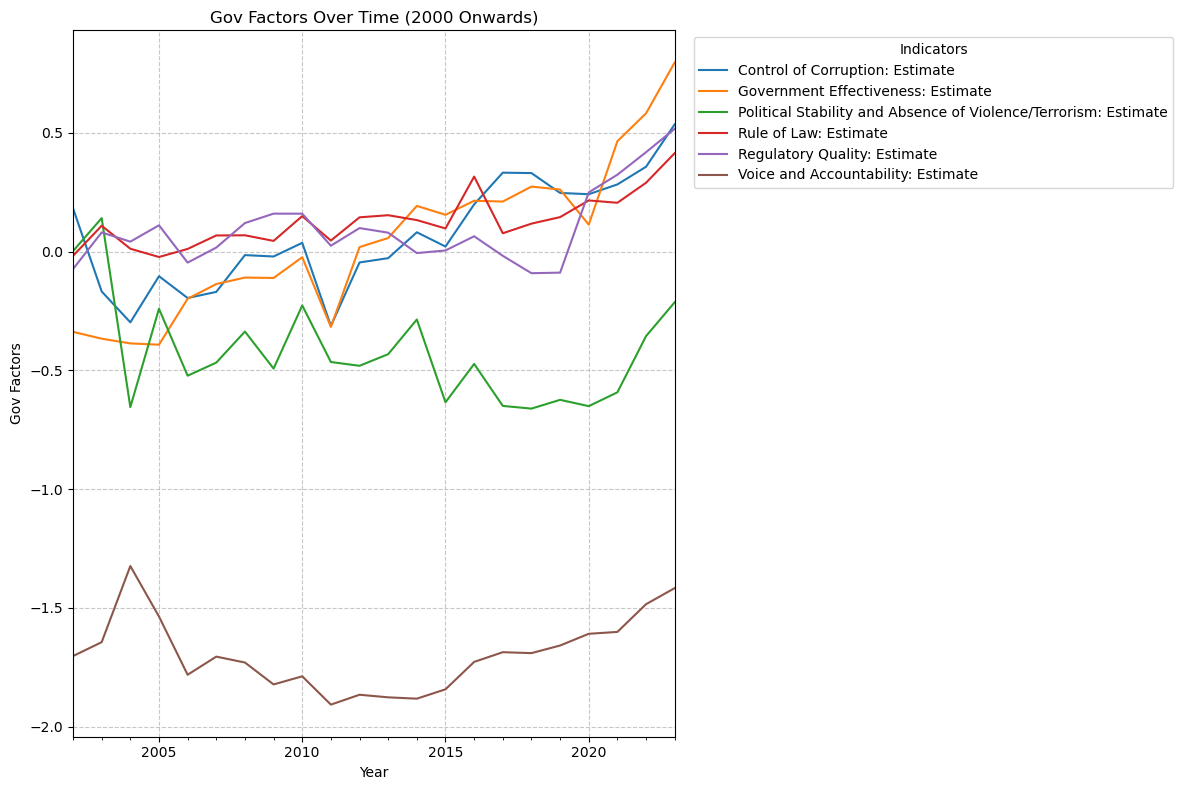

In [42]:
##Plot Looking at Governance Factors of Saudi Arabia

SOURCE = 3 # "Worldwide Governance Indicators"
governance_variables = {
    "CC.EST": "Control of Corruption: Estimate",
    "GE.EST": "Government Effectiveness: Estimate",
    "PV.EST": "Political Stability and Absence of Violence/Terrorism: Estimate",
    "RL.EST": "Rule of Law: Estimate",
    "RQ.EST": "Regulatory Quality: Estimate",
    "VA.EST": "Voice and Accountability: Estimate"}
gov = wbdata.get_dataframe(governance_variables, country="SAU",parse_dates=True)
gov.dropna()
gov_filtered = gov[gov.index.year >= 2002]

#plot
ax = gov_filtered.plot(
    figsize=(12, 8),
    title="Gov Factors Over Time (2000 Onwards)",
    xlabel="Year",
    ylabel="Gov Factors",
    grid=True,)
plt.legend(title="Indicators", loc="upper left", bbox_to_anchor=(1.02, 1), fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Context/Explanation of Heatmap**:

Saudi Arabia’s governance, as shown in the heatmap, demonstrates a strong correlation between Control of Corruption (0.86) and Government Effectiveness (0.86), highlighting the impact of anti-corruption efforts on administrative efficiency. However, Political Stability negatively correlates with both (-0.30, -0.36), reflecting challenges from regional conflicts and economic transitions. Rule of Law (0.69) and Regulatory Quality (0.54) are moderately linked to corruption control, indicating progress but also the need for clearer legal frameworks. Notably, Voice and Accountability shows weak correlations (≤ 0.19) with other governance factors, reinforcing the monarchy’s centralized control and limited political freedoms. This reflects Saudi Arabia’s authoritarian efficiency model, where governance and economic reforms advance while political liberalization remains minimal.

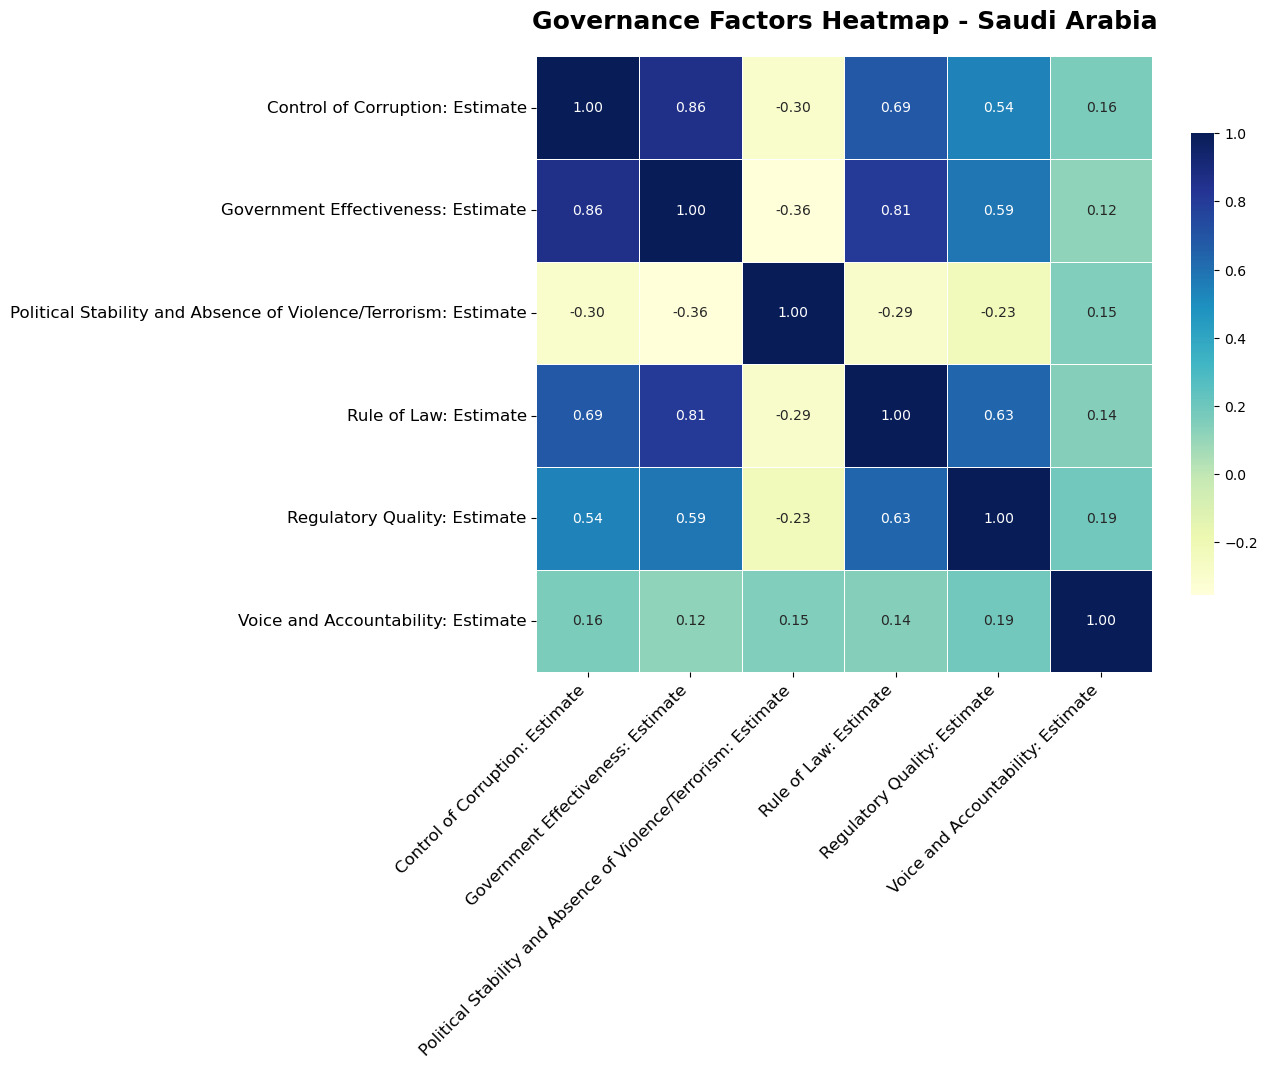

In [43]:
#Heat Map of Governance Factors of Saudi Arabia

# Set figure size for better readability
plt.figure(figsize=(10, 8))

# Create a heatmap with improved aesthetics
sns.heatmap(
    gov.corr(), 
    annot=True, 
    fmt=".2f", 
    cmap="YlGnBu",  # More intuitive color scheme
    linewidths=0.5,  # Add gridlines for clarity
    square=True,  # Ensure heatmap cells are square
    cbar_kws={'shrink': 0.75},  # Adjust color bar size
    annot_kws={"size": 10}  # Set font size for annotations
)

# Improve title readability
plt.title("Governance Factors Heatmap - Saudi Arabia", fontsize=18, fontweight='bold', pad=20)

# Rotate x and y labels for clarity
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# Show plot
plt.show()

# Deliverable 8: Agricultural Supply

**Saudi Arabia's Population & Agricultural Production**

Saudi Arabia's economic and social development is intertwined with its evolving population dynamics and agricultural production. This presentation explores the historical interplay of these factors, analyzing government policies, technological advancements, and the implications for the nation's future.


**Saudization Policy**


The Saudization policy, also known as the Nitaqat program, aimed to prioritize local employment over foreign workers. This initiative, initiated in 2011, significantly reshaped the Saudi labor force, impacting industries heavily reliant on migrant labor, including agriculture.


**Vision 2030 & Economic Diversification**

Vision 2030, launched in 2016, focuses on economic diversification, shifting away from oil dependence toward sectors like tourism, technology, and non-oil industries. This economic transformation influences migration patterns, population demographics, and the government's agricultural investments.


**Impact of Expatriate Labor Policies**

Saudi Arabia's approach to expatriate labor has undergone significant transformation, particularly affecting the agricultural sector.


1. **Traditional Labor Structure**: Heavy reliance on expatriate workforce in low-wage sectors, creating a diverse but dependent agricultural labor market.

2. **Policy Evolution**: Implementation of stricter labor laws and expatriate fees, significantly influencing farm labor availability and costs.

3. **Current Transformation**: Strategic shift towards skilled worker recruitment and local employment, balancing labor diversity with economic efficiency in agriculture.


**Historical Shifts in Agricultural Policy**

1. **Wheat Subsidy & Water Crisis**: The government heavily subsidized wheat farming from the 1970s to 2008, making Saudi Arabia a top producer. However, this led to severe groundwater depletion.

2. **Food Security Strategies**: In response to the water crisis, the government reduced wheat production and increased reliance on imports. Saudi Arabia also invested in farmland abroad to secure its food supply.


3. **Smart & Sustainable Agriculture**: Recent investments in hydroponics, desalination-based farming, and vertical farms aim to address climate challenges and
promote sustainable agriculture.

**Impact of Historical Events**

1. **Pre-1938: Early Settlements & Traditional Agriculture**

Traditional oasis farming and small-scale irrigation systems sustained limited agricultural output. Nomadic Bedouin populations primarily relied on
livestock and trade.


2. **1938: Oil Discovery & Urbanization**

The discovery of oil transformed Saudi Arabia, shifting focus from an agrarian economy to an oil- driven urban economy. Massive urbanization led to rural-to-urban migration and a decline in traditional farming.



4. **1960s-1970s: Arab-Israeli Conflicts & Food Security**


Middle Eastern conflicts disrupted regional trade, leading to increased food security concerns. Saudi Arabia prioritized self-sufficiency policies during the
Cold War era.


6. **1990-1991: Gulf War & Migration Changes**


The Gulf War led to the expulsion of Yemeni and Jordanian workers, affecting labor supply. A shift in labor policy resulted in a higher reliance on South Asian workers.


8. **Present Day: Climate Change & Desertification**

Historical overuse of water resources has made food production unsustainable. The government is focusing on sustainable agricultural techniques and food
imports.


**Agricultural Supply & Population Growth**

1. **Population Growth:** Saudi Arabia's population has grown rapidly, from around 4 million in 1960 to over 35 million today.



2. **Agricultural Production:** Despite government investments in irrigation projects and wheat production subsidies, the country remains heavily dependent on food imports due to its arid climate.



3. **Water Scarcity:** Limited water resources restrict sustainable food production, making agricultural expansion challenging.



4. **Urbanization & Imports:** Increasing urbanization and reliance on food imports create a system where supply must be maintained through
external trade.

**The Malthusian Perspective**

1. **Malthusian Concerns:** Thomas Malthus argued that unchecked population growth would outstrip resource availability, leading to resource scarcity and societal instability.




2. **Food Security Risks:** Malthus might argue that Saudi Arabia's rapid population growth could lead to food insecurity if imports were disrupted due to its heavy reliance on imported food.




3. **Vulnerability:** The country is susceptible to external shocks such as global supply chain disruptions, climate change, and geopolitical issues, making its food security precarious.


# Deliverable 2: Unit Tests

In [44]:
#Deliverable 1 Unit Test

In [45]:
## Test will pass if it returns true 

## Unit Test 1
result = population(2002, "p", [0, 100], "China")
population_amount = int(result.split()[2].replace(",", ""))  # Extract population
print("True" if population_amount < 3024320000 else "Population wrong")  # Less than 3 billion in China in 2002

## Unit Test 2
result = population(2020, "females", [10, 19], "United States")
population_amount = int(result.split()[2].replace(",", ""))  # Extract population
print("True" if 5000000 < population_amount < 30000000 else "Population wrong")  # Reasonable range for 10-19 females in 2020

## Unit Test 3
result = population(2023, "everyone", [20, 29], "WLD")
population_amount = int(result.split()[2].replace(",", ""))  # Extract population
print("True" if 500000000 < population_amount < 2000000000 else "Population wrong")  # Should be in billions but not too high

## Unit Test 4
result = population(2023, "everyone", [65, 85], "USA")
population_amount = int(result.split()[2].replace(",", ""))  # Extract population
print("True" if 30000000 < population_amount < 80000000 else "Population wrong")  # Reasonable range for elderly population

## Unit Test 5
result = population(1975, "People", [5, 7], "Rwanda")
population_amount = int(result.split()[2].replace(",", ""))  # Extract population
print("True" if population_amount < 5000000 else "Population wrong")  # Rwanda had a much smaller population in 1975

True
True
True
True
True


In [46]:
#Deliverable 3 Unit Test

In [47]:
def test_population_breakdown():
    try:
        df = population_breakdown(["SAU", "WLD"], [2021, 2023], gender="All", min_age=16, max_age=50)
        assert not df.empty, "Test 1 failed: Dataframe is empty"
        print("Test 1 passed: Dataframe is not empty")
    except Exception as e:
        print(f"Test 1 failed with error: {e}")
    
    try:
        expected_years = [2021, 2023]
        assert all(year in df.columns.levels[1] for year in expected_years), "Test 2 failed: Missing expected years"
        print("Test 2 passed: Expected years are present")
    except Exception as e:
        print(f"Test 2 failed with error: {e}")
    
    try:
        expected_age_groups = [
            "Ages from: 15 to 19, Sex:ALL", "Ages from: 20 to 24, Sex:ALL", "Ages from: 25 to 29, Sex:ALL",
            "Ages from: 30 to 34, Sex:ALL", "Ages from: 35 to 39, Sex:ALL", "Ages from: 40 to 44, Sex:ALL"
        ]
        assert all(age in df.index for age in expected_age_groups), "Test 3 failed: Missing expected age groups"
        print("Test 3 passed: Expected age groups are present")
    except Exception as e:
        print(f"Test 3 failed with error: {e}")

test_population_breakdown()

Test 1 passed: Dataframe is not empty
Test 2 passed: Expected years are present
Test 3 passed: Expected age groups are present


In [48]:
#Deliverable 4 Unit Test

In [49]:
## Test will pass if it returns true 

# Test for a valid year in the dataset
result = population_pyramid(sau_df, '2010')
print("True" if isinstance(result, go.Figure) else "Function error")  # Should return a Plotly Figure object

# Test that the function correctly handles data without any missing age groups
all_ages_present = all(f"Males {age}" in sau_df.columns and f"Females {age}" in sau_df.columns for age in age_ranges)
print("True" if all_ages_present else "Missing age groups in dataset")

# Test that the function returns a bar chart with the expected number of traces (Male & Female)
valid_fig = population_pyramid(sau_df, '2010')
print("True" if isinstance(valid_fig, go.Figure) and len(valid_fig.data) == 2 else "Plot structure error")  # Should have 2 traces

# Test that the function does not break if the input DataFrame has extra columns
extra_col_df = sau_df.copy()
extra_col_df["Extra Column"] = 1  # Adding an irrelevant column
result_extra = population_pyramid(extra_col_df, '2010')
print("True" if isinstance(result_extra, go.Figure) else "Function error with extra columns")


True
True
True
True
